# Lab-2.1 Part 1: Triton Inference Server 設置與安裝

## 🎯 學習目標
- 理解 Triton Inference Server 架構
- 安裝和配置 Triton Server
- 驗證基礎推理功能
- 了解 REST 和 gRPC API

## ⏱️ 預估時間: 60-90 分鐘

---

## 1. 環境驗證與準備

In [6]:
# 檢查系統環境
import sys
import subprocess
import torch
import os
from pathlib import Path

print("🔍 Triton Server 環境檢查")
print("=" * 50)

# 基礎環境
print(f"Python 版本: {sys.version.split()[0]}")
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA 版本: {torch.version.cuda}")
    print(f"GPU 數量: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        gpu = torch.cuda.get_device_properties(i)
        memory_gb = gpu.total_memory / 1e9
        print(f"  GPU {i}: {gpu.name} ({memory_gb:.1f} GB)")
        print(f"    計算能力: {gpu.major}.{gpu.minor}")
else:
    print("⚠️ 警告: 未檢測到 CUDA GPU")
    print("Triton Server 需要 GPU 以獲得最佳性能")

🔍 Triton Server 環境檢查
Python 版本: 3.10.12
PyTorch 版本: 2.8.0+cu128
CUDA 可用: True
CUDA 版本: 12.8
GPU 數量: 1
  GPU 0: NVIDIA RTX 2000 Ada Generation (16.7 GB)
    計算能力: 8.9


In [13]:
# 檢查 Docker 環境
def check_docker():
    """檢查 Docker 是否安裝並支援 GPU"""
    try:
        # 檢查 Docker 版本
        result = subprocess.run(['docker', '--version'], 
                               capture_output=True, text=True)
        if result.returncode == 0:
            print(f"✅ Docker: {result.stdout.strip()}")
        else:
            print("❌ Docker 未安裝")
            return False
            
        # 檢查 Docker 權限
        result = subprocess.run(['docker', 'ps'], 
                               capture_output=True, text=True)
        if result.returncode == 0:
            print("✅ Docker 權限正常")
        else:
            print("⚠️ Docker 權限問題，可能需要 sudo")
            
        # 檢查 NVIDIA Container Toolkit
        result = subprocess.run(['docker', 'run', '--rm', '--gpus', 'all', 
                               'nvidia/cuda:11.0.3-base-ubuntu20.04', 
                               'nvidia-smi', '--list-gpus'], 
                               capture_output=True, text=True, timeout=30)
        if result.returncode == 0:
            gpu_count = len(result.stdout.strip().split('\n'))
            print(f"✅ Docker GPU 支援: 檢測到 {gpu_count} 個 GPU")
            return True
        else:
            print("❌ Docker GPU 支援未配置")
            print("請安裝 NVIDIA Container Toolkit")
            return False
            
    except subprocess.TimeoutExpired:
        print("⏱️ Docker GPU 檢查超時")
        return False
    except FileNotFoundError:
        print("❌ Docker 命令未找到")
        return False
    except Exception as e:
        print(f"❌ Docker 檢查錯誤: {e}")
        return False

docker_ready = check_docker()

✅ Docker: Docker version 28.4.0, build d8eb465
✅ Docker 權限正常
✅ Docker GPU 支援: 檢測到 1 個 GPU


---
## 2. Triton Server 安裝

In [14]:
# 安裝 Triton 客戶端庫
print("📦 安裝 Triton 客戶端庫...")

try:
    import tritonclient.http as httpclient
    import tritonclient.grpc as grpcclient
    print("✅ tritonclient 已安裝")
except ImportError:
    print("❌ tritonclient 未安裝")
    print("\n安裝命令:")
    print("  pip install tritonclient[all]")
    print("\n請在終端執行上述命令後重新運行此 cell")

# 檢查 Triton Server Docker 映像
def check_triton_image():
    """檢查 Triton Server Docker 映像"""
    try:
        result = subprocess.run(['docker', 'images', 'nvcr.io/nvidia/tritonserver'], 
                               capture_output=True, text=True)
        
        if 'tritonserver' in result.stdout:
            print("✅ Triton Server 映像已存在")
            return True
        else:
            print("❌ Triton Server 映像未找到")
            print("\n下載命令:")
            print("docker pull nvcr.io/nvidia/tritonserver:25.05-py3")
            return False
            
    except Exception as e:
        print(f"❌ 檢查映像時出錯: {e}")
        return False

triton_image_ready = check_triton_image()

if not triton_image_ready:
    print("\n⏳ 下載 Triton Server 映像 (這可能需要幾分鐘)...")
    print("\n在終端執行:")
    print(" docker pull nvcr.io/nvidia/tritonserver:25.05-py3")

📦 安裝 Triton 客戶端庫...
✅ tritonclient 已安裝
✅ Triton Server 映像已存在


---
## 3. 模型倉庫準備

In [15]:
# 創建 Triton 模型倉庫結構
import os
from pathlib import Path

# 設置工作目錄
work_dir = Path.cwd()
model_repo_dir = work_dir / "model_repository"

print(f"📁 創建模型倉庫: {model_repo_dir}")

# 創建模型倉庫結構
def create_model_repository():
    """
    創建標準的 Triton 模型倉庫結構
    """
    # 基礎目錄結構
    directories = [
        "model_repository",
        "model_repository/simple_pytorch_model",
        "model_repository/simple_pytorch_model/1",
        "model_repository/simple_pytorch_model/config",
    ]
    
    for dir_path in directories:
        os.makedirs(dir_path, exist_ok=True)
        print(f"  ✅ {dir_path}")
    
    print(f"\n📋 標準模型倉庫結構:")
    print("""
    model_repository/
    └── simple_pytorch_model/          # 模型名稱
        ├── config.pbtxt               # 模型配置文件
        ├── 1/                         # 版本號
        │   └── model.pt               # 模型權重文件
        └── config/                    # 額外配置 (可選)
    """)

create_model_repository()

print("\n💡 Triton 模型倉庫設計原則:")
print("• 每個模型有獨立的目錄")
print("• 版本號目錄包含模型檔案")
print("• config.pbtxt 定義模型配置")
print("• 支援多版本並行部署")

📁 創建模型倉庫: /home/os-sunnie.gd.weng/python_workstation/side-project/iSpan_LLM-One-Piece/02-Efficient_Inference_and_Serving/02-Labs/Triton_Track/Lab-2.1-Triton_Server_Basics/model_repository
  ✅ model_repository
  ✅ model_repository/simple_pytorch_model
  ✅ model_repository/simple_pytorch_model/1
  ✅ model_repository/simple_pytorch_model/config

📋 標準模型倉庫結構:

    model_repository/
    └── simple_pytorch_model/          # 模型名稱
        ├── config.pbtxt               # 模型配置文件
        ├── 1/                         # 版本號
        │   └── model.pt               # 模型權重文件
        └── config/                    # 額外配置 (可選)
    

💡 Triton 模型倉庫設計原則:
• 每個模型有獨立的目錄
• 版本號目錄包含模型檔案
• config.pbtxt 定義模型配置
• 支援多版本並行部署


In [16]:
# 創建簡單的 PyTorch 模型用於測試
import torch
import torch.nn as nn
import numpy as np

class SimpleTextClassifier(nn.Module):
    """
    簡單的文本分類模型，用於 Triton 部署測試
    """
    def __init__(self, vocab_size=1000, embed_dim=128, num_classes=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, input_ids):
        # input_ids: [batch_size, seq_len]
        x = self.embedding(input_ids)  # [batch_size, seq_len, embed_dim]
        x = torch.mean(x, dim=1)       # [batch_size, embed_dim] - 簡單的平均池化
        x = torch.relu(self.fc1(x))    # [batch_size, 64]
        x = self.dropout(x)
        output = self.fc2(x)           # [batch_size, num_classes]
        return torch.softmax(output, dim=-1)

# 創建和保存模型
print("🤖 創建測試用 PyTorch 模型...")

model = SimpleTextClassifier(vocab_size=1000, embed_dim=128, num_classes=3)
model.eval()

# 創建示例輸入
example_input = torch.randint(0, 1000, (1, 10))  # batch=1, seq_l en=10
print(f"示例輸入形狀: {example_input.shape}")

# 測試模型
with torch.no_grad():
    output = model(example_input)
    print(f"模型輸出形狀: {output.shape}")
    print(f"輸出機率: {output.numpy().round(3)}")

# 轉換為 TorchScript (Triton 推薦格式)
traced_model = torch.jit.trace(model, example_input)

# 保存模型到倉庫
model_path = model_repo_dir / "simple_pytorch_model" / "1" / "model.pt"
traced_model.save(str(model_path))

print(f"✅ 模型已保存到: {model_path}")
print(f"✅ 模型大小: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")

🤖 創建測試用 PyTorch 模型...
示例輸入形狀: torch.Size([1, 10])
模型輸出形狀: torch.Size([1, 3])
輸出機率: [[0.325 0.306 0.369]]
✅ 模型已保存到: /home/os-sunnie.gd.weng/python_workstation/side-project/iSpan_LLM-One-Piece/02-Efficient_Inference_and_Serving/02-Labs/Triton_Track/Lab-2.1-Triton_Server_Basics/model_repository/simple_pytorch_model/1/model.pt
✅ 模型大小: 0.53 MB


In [17]:
# 創建 Triton 模型配置文件
config_content = '''
name: "simple_pytorch_model"
platform: "pytorch_libtorch"
max_batch_size: 32
input [
  {
    name: "INPUT__0"
    data_type: TYPE_INT64
    dims: [ 10 ]
  }
]
output [
  {
    name: "OUTPUT__0"
    data_type: TYPE_FP32
    dims: [ 3 ]
  }
]

# 動態批次處理配置
dynamic_batching {
  # 偏好的批次大小
  preferred_batch_size: [ 4, 8, 16 ]
  
  # 最大等待時間 (微秒)
  max_queue_delay_microseconds: 5000
  
  # 保持順序
  preserve_ordering: true
}

# 實例組配置 (可選)
instance_group [
  {
    count: 1
    kind: KIND_GPU
  }
]

# 版本策略
version_policy: { latest { num_versions: 1}}
'''

# 保存配置文件
config_path = model_repo_dir / "simple_pytorch_model" / "config.pbtxt"
with open(config_path, 'w') as f:
    f.write(config_content.strip())

print(f"✅ 模型配置文件已創建: {config_path}")

# 檢查模型倉庫結構
print(f"\n📂 模型倉庫結構:")
for root, dirs, files in os.walk(model_repo_dir):
    level = root.replace(str(model_repo_dir), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        size = os.path.getsize(os.path.join(root, file))
        size_str = f"{size/1024:.1f}KB" if size < 1024*1024 else f"{size/1024/1024:.1f}MB"
        print(f"{subindent}{file} ({size_str})")

✅ 模型配置文件已創建: /home/os-sunnie.gd.weng/python_workstation/side-project/iSpan_LLM-One-Piece/02-Efficient_Inference_and_Serving/02-Labs/Triton_Track/Lab-2.1-Triton_Server_Basics/model_repository/simple_pytorch_model/config.pbtxt

📂 模型倉庫結構:
model_repository/
  simple_pytorch_model/
    config.pbtxt (0.6KB)
    1/
      model.pt (544.7KB)
    config/


---
## 4. 啟動 Triton Server

In [18]:
# 啟動 Triton Server (Docker 容器)
import subprocess
import time
import requests

def start_triton_server():
    """
    啟動 Triton Inference Server
    """
    # Triton Server Docker 命令
    model_repo_path = str(model_repo_dir.absolute())
    
    docker_cmd = [
        'docker', 'run', '--rm', '-d',
        '--name', 'triton-server',
        '--gpus', 'all',
        '-p', '8000:8000',  # HTTP port
        '-p', '8001:8001',  # gRPC port  
        '-p', '8002:8002',  # Metrics port
        '-v', f'{model_repo_path}:/models',
        'nvcr.io/nvidia/tritonserver:25.05-py3',
        'tritonserver',
        '--model-repository=/models',
        '--strict-model-config=false',
        '--log-verbose=1'
    ]

    print("🚀 啟動 Triton Server...")
    print(f"模型倉庫路徑: {model_repo_path}")
    
    try:
        # 停止現有容器 (如果存在)
        subprocess.run(['docker', 'stop', 'triton-server'], 
                      capture_output=True, text=True)
        
        # 啟動新容器
        result = subprocess.run(docker_cmd, capture_output=True, text=True)
        
        if result.returncode == 0:
            container_id = result.stdout.strip()
            print(f"✅ Triton Server 容器已啟動: {container_id[:12]}")
            
            # 等待服務啟動
            print("⏳ 等待服務就緒...")
            
            for attempt in range(30):  # 最多等待 30 秒
                time.sleep(1)
                try:
                    response = requests.get('http://localhost:8000/v2/health/ready', 
                                          timeout=2)
                    if response.status_code == 200:
                        print(f"✅ Triton Server 就緒! (耗時 {attempt+1} 秒)")
                        return True
                except requests.exceptions.RequestException:
                    pass
                    
                if attempt % 5 == 4:
                    print(f"   仍在啟動中... ({attempt+1}/30)")
            
            print("❌ Triton Server 啟動超時")
            return False
            
        else:
            print(f"❌ 啟動失敗: {result.stderr}")
            return False
            
    except Exception as e:
        print(f"❌ 啟動異常: {e}")
        return False

server_ready = start_triton_server()

if server_ready:
    print("\n🌐 Triton Server 端點:")
    print("  • HTTP API: http://localhost:8000")
    print("  • gRPC API: localhost:8001")
    print("  • Metrics: http://localhost:8002/metrics")
    print("  • Health: http://localhost:8000/v2/health/ready")

🚀 啟動 Triton Server...
模型倉庫路徑: /home/os-sunnie.gd.weng/python_workstation/side-project/iSpan_LLM-One-Piece/02-Efficient_Inference_and_Serving/02-Labs/Triton_Track/Lab-2.1-Triton_Server_Basics/model_repository
✅ Triton Server 容器已啟動: 5e851787878b
⏳ 等待服務就緒...
✅ Triton Server 就緒! (耗時 2 秒)

🌐 Triton Server 端點:
  • HTTP API: http://localhost:8000
  • gRPC API: localhost:8001
  • Metrics: http://localhost:8002/metrics
  • Health: http://localhost:8000/v2/health/ready


---
## 5. Triton API 基礎測試

In [19]:
# 測試 Triton Server HTTP API
import requests
import json
import numpy as np

TRITON_HTTP_URL = "http://localhost:8000"

def test_server_health():
    """
    測試服務器健康狀態
    """
    try:
        # 檢查服務器健康
        health_url = f"{TRITON_HTTP_URL}/v2/health/ready"
        response = requests.get(health_url)
        
        if response.status_code == 200:
            print("✅ Triton Server 健康檢查通過")
            return True
        else:
            print(f"❌ 健康檢查失敗: {response.status_code}")
            return False
            
    except Exception as e:
        print(f"❌ 健康檢查異常: {e}")
        return False

def get_server_metadata():
    """
    獲取服務器元數據
    """
    try:
        metadata_url = f"{TRITON_HTTP_URL}/v2"
        response = requests.get(metadata_url)
        
        if response.status_code == 200:
            metadata = response.json()
            print(f"✅ 服務器版本: {metadata.get('version', 'Unknown')}")
            print(f"✅ 服務器名稱: {metadata.get('name', 'Unknown')}")
            return metadata
        else:
            print(f"❌ 獲取元數據失敗: {response.status_code}")
            return None
            
    except Exception as e:
        print(f"❌ 元數據查詢異常: {e}")
        return None

def list_models():
    try:
        # 使用正確的端點和方法
        models_url = f"{TRITON_HTTP_URL}/v2/repository/index"
        response = requests.post(models_url)  # 改為 POST

        if response.status_code == 200:
            models = response.json()
            print(f"📋 已載入模型數量: {len(models)}")

            for model in models:
                model_name = model['name']
                model_version = model['version']
                model_state = model['state']
                print(f"  • {model_name} v{model_version}: {model_state}")

            return models
        else:
            print(f"❌ 模型列表獲取失敗: {response.status_code}")
            return None

    except Exception as e:
        print(f"❌ 模型查詢異常: {e}")
        return None

# 執行基礎測試
print("🧪 Triton Server 基礎測試")
print("=" * 40)

if test_server_health():
    metadata = get_server_metadata()
    models = list_models()
    
    if not models:
        print("\n⚠️ 沒有模型被載入，檢查模型倉庫配置")
else:
    print("\n❌ Triton Server 未正常運行")
    print("請檢查 Docker 容器狀態: docker logs triton-server")


🧪 Triton Server 基礎測試
✅ Triton Server 健康檢查通過
✅ 服務器版本: 2.58.0
✅ 服務器名稱: triton
📋 已載入模型數量: 1
  • simple_pytorch_model v1: READY


In [24]:
# 使用 Triton 客戶端進行推理測試
if 'tritonclient' in globals() or True:  # 假設已安裝
    try:
        import tritonclient.http as httpclient
        import tritonclient.utils as utils
        
        print("🎯 Triton 客戶端推理測試")
        print("=" * 40)
        
        # 創建客戶端
        triton_client = httpclient.InferenceServerClient(
            url='localhost:8000',
            verbose=False
        )
        
        # 檢查模型是否就緒
        model_name = "simple_pytorch_model"
        
        if triton_client.is_model_ready(model_name):
            print(f"✅ 模型 '{model_name}' 就緒")
            
            # 獲取模型元數據
            model_metadata = triton_client.get_model_metadata(model_name)
            
            # Handle both dict and object-like metadata
            if isinstance(model_metadata, dict):
                versions = model_metadata.get('versions', ['1'])
                platform = model_metadata.get('platform', 'unknown')
            else:
                versions = getattr(model_metadata, 'versions', ['1'])
                platform = getattr(model_metadata, 'platform', 'unknown')
            
            print(f"✅ 模型版本: {versions}")
            print(f"✅ 模型平台: {platform}")
            
            # 準備推理數據
            input_data = np.random.randint(0, 1000, (1, 10), dtype=np.int64)
            print(f"📊 輸入數據形狀: {input_data.shape}")
            
            # 創建推理請求
            inputs = [
                httpclient.InferInput("INPUT__0", input_data.shape, "INT64")
            ]
            inputs[0].set_data_from_numpy(input_data)
            
            outputs = [
                httpclient.InferRequestedOutput("OUTPUT__0")
            ]
            
            # 執行推理
            start_time = time.time()
            response = triton_client.infer(
                model_name=model_name,
                inputs=inputs,
                outputs=outputs
            )
            inference_time = time.time() - start_time
            
            # 獲取結果
            output_data = response.as_numpy("OUTPUT__0")
            
            print(f"\n🎯 推理結果:")
            print(f"  輸入: {input_data.flatten()[:5]}... (顯示前5個)")
            print(f"  輸出機率: {output_data.round(4)}")
            print(f"  預測類別: {np.argmax(output_data)}")
            print(f"  推理時間: {inference_time*1000:.2f} ms")
            
            print("\n✅ Triton 推理測試成功!")
            
        else:
            print(f"❌ 模型 '{model_name}' 未就緒")
            print("檢查模型配置和倉庫結構")
            
    except ImportError:
        print("❌ tritonclient 未安裝")
        print("安裝命令: pip install tritonclient[all]")
    except Exception as e:
        print(f"❌ 推理測試失敗: {e}")
        print("\n📋 故障排除建議:")
        print("1. 檢查 Triton Server 是否運行: docker ps")
        print("2. 查看服務器日誌: docker logs triton-server")
        print("3. 驗證模型配置文件語法")
        print("4. 確認模型文件存在且可讀取")



🎯 Triton 客戶端推理測試
✅ 模型 'simple_pytorch_model' 就緒
✅ 模型版本: ['1']
✅ 模型平台: pytorch_libtorch
📊 輸入數據形狀: (1, 10)

🎯 推理結果:
  輸入: [547 414 844  10 512]... (顯示前5個)
  輸出機率: [[0.3184 0.3428 0.3388]]
  預測類別: 1
  推理時間: 8.22 ms

✅ Triton 推理測試成功!


---
## 6. REST API 詳細探索

In [26]:
# 探索 Triton REST API
import requests
import json

def explore_triton_api():
    """
    探索 Triton Server REST API 端點
    """
    base_url = "http://localhost:8000"
    
    # Define endpoints with their HTTP methods
    endpoints = {
        "服務器元數據": ("GET", "/v2"),
        "健康檢查 (Live)": ("GET", "/v2/health/live"),
        "健康檢查 (Ready)": ("GET", "/v2/health/ready"),
        "模型列表": ("POST", "/v2/repository/index"),  # POST request for model listing
        "模型元數據": ("GET", "/v2/models/simple_pytorch_model"),
        "模型配置": ("GET", "/v2/models/simple_pytorch_model/config"),
        "模型統計": ("GET", "/v2/models/simple_pytorch_model/stats"),
        "服務器統計": ("GET", "/v2/models/stats"),
    }
    
    print("🌐 Triton REST API 探索")
    print(f"Triton 版本: 2.58.0")
    print("=" * 50)
    
    for description, (method, endpoint) in endpoints.items():
        try:
            url = base_url + endpoint
            
            # Use appropriate HTTP method
            if method == "POST":
                response = requests.post(url, timeout=5)
            else:
                response = requests.get(url, timeout=5)
            
            if response.status_code == 200:
                print(f"\n✅ {description}:")
                print(f"   {method} {endpoint}")
                
                # Check if response has content and is JSON
                content_type = response.headers.get('Content-Type', '')
                response_text = response.text.strip()
                
                # Handle health check endpoints (may return empty or non-JSON)
                if 'health' in endpoint:
                    if response_text:
                        print(f"   狀態: {response_text}")
                    else:
                        print(f"   狀態: OK (empty response)")
                    print(f"   響應大小: {len(response.text)} bytes")
                # Handle JSON responses
                elif 'application/json' in content_type or response_text.startswith('{') or response_text.startswith('['):
                    try:
                        data = response.json()
                        
                        # Handle model list (array format)
                        if isinstance(data, list):
                            print(f"   模型數量: {len(data)}")
                            for i, model in enumerate(data[:5], 1):  # Show first 5 models
                                name = model.get('name', 'N/A')
                                version = model.get('version', 'N/A')
                                state = model.get('state', 'N/A')
                                print(f"   [{i}] {name} (版本: {version}, 狀態: {state})")
                            if len(data) > 5:
                                print(f"   ... 還有 {len(data) - 5} 個模型未顯示")
                        # Handle object format
                        else:
                            # 顯示關鍵信息
                            if "version" in data:
                                print(f"   版本: {data['version']}")
                                
                            if "name" in data:
                                print(f"   名稱: {data['name']}")
                                
                            if "platform" in data:
                                print(f"   平台: {data['platform']}")
                                
                            if "max_batch_size" in data:
                                print(f"   最大批次: {data['max_batch_size']}")
                            
                            # Show inputs/outputs for model metadata
                            if "inputs" in data:
                                print(f"   輸入: {len(data['inputs'])} 個")
                                for inp in data['inputs'][:3]:  # Show first 3 inputs
                                    print(f"      - {inp.get('name')}: {inp.get('datatype')} {inp.get('shape')}")
                            
                            if "outputs" in data:
                                print(f"   輸出: {len(data['outputs'])} 個")
                                for out in data['outputs'][:3]:  # Show first 3 outputs
                                    print(f"      - {out.get('name')}: {out.get('datatype')} {out.get('shape')}")
                        
                        # 顯示響應大小
                        response_size = len(response.text)
                        print(f"   響應大小: {response_size} bytes")
                    except json.JSONDecodeError:
                        print(f"   ⚠️ 無法解析 JSON，響應: {response_text[:100]}")
                        print(f"   響應大小: {len(response.text)} bytes")
                else:
                    # Non-JSON response
                    print(f"   響應類型: {content_type}")
                    print(f"   響應內容: {response_text[:100] if response_text else '(empty)'}")
                    print(f"   響應大小: {len(response.text)} bytes")
                
            else:
                print(f"❌ {description}: HTTP {response.status_code}")
                print(f"   {method} {endpoint}")
                if response.text:
                    print(f"   錯誤訊息: {response.text[:100]}")
                
        except requests.exceptions.RequestException as e:
            print(f"❌ {description}: 網路錯誤")
            print(f"   {method} {endpoint}")
            print(f"   錯誤: {e}")
        except Exception as e:
            print(f"❌ {description}: 未知錯誤")
            print(f"   {method} {endpoint}")
            print(f"   {type(e).__name__}: {e}")

explore_triton_api()

print("\n📚 API 文檔參考:")
print("• Triton HTTP API: https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_model_repository.md")
print("• gRPC API: https://github.com/triton-inference-server/common/blob/main/protobuf/grpc_service.proto")

🌐 Triton REST API 探索
Triton 版本: 2.58.0

✅ 服務器元數據:
   GET /v2
   版本: 2.58.0
   名稱: triton
   響應大小: 285 bytes

✅ 健康檢查 (Live):
   GET /v2/health/live
   狀態: OK (empty response)
   響應大小: 0 bytes

✅ 健康檢查 (Ready):
   GET /v2/health/ready
   狀態: OK (empty response)
   響應大小: 0 bytes

✅ 模型列表:
   POST /v2/repository/index
   模型數量: 1
   [1] simple_pytorch_model (版本: 1, 狀態: READY)
   響應大小: 63 bytes

✅ 模型元數據:
   GET /v2/models/simple_pytorch_model
   名稱: simple_pytorch_model
   平台: pytorch_libtorch
   輸入: 1 個
      - INPUT__0: INT64 [-1, 10]
   輸出: 1 個
      - OUTPUT__0: FP32 [-1, 3]
   響應大小: 210 bytes

✅ 模型配置:
   GET /v2/models/simple_pytorch_model/config
   名稱: simple_pytorch_model
   平台: pytorch_libtorch
   最大批次: 32
   響應大小: 1171 bytes

✅ 模型統計:
   GET /v2/models/simple_pytorch_model/stats
   響應大小: 637 bytes

✅ 服務器統計:
   GET /v2/models/stats
   響應大小: 637 bytes

📚 API 文檔參考:
• Triton HTTP API: https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_model_repository.md
• 

🚀 批次推理性能測試

📊 批次大小  1:
   平均時間: 9.16 ms
   吞吐量: 109.1 samples/sec
   單樣本延遲: 9.16 ms

📊 批次大小  4:
   平均時間: 2.16 ms
   吞吐量: 1848.0 samples/sec
   單樣本延遲: 0.54 ms

📊 批次大小  8:
   平均時間: 1.10 ms
   吞吐量: 7251.6 samples/sec
   單樣本延遲: 0.14 ms

📊 批次大小 16:
   平均時間: 1.42 ms
   吞吐量: 11281.1 samples/sec
   單樣本延遲: 0.09 ms


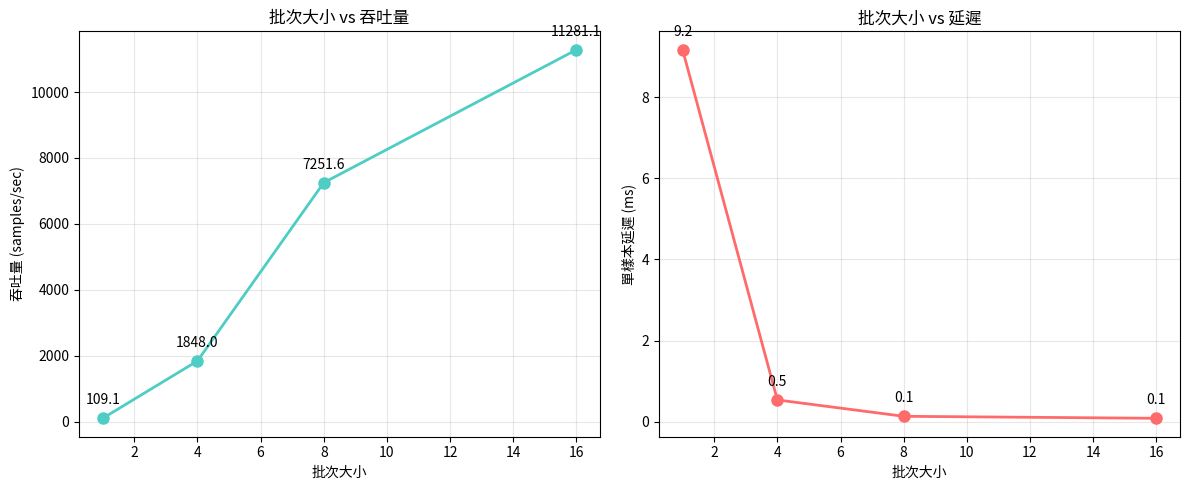


📈 性能分析:
  最高吞吐量: 11281.1 samples/sec (批次=16)
  最低延遲: 0.1 ms (批次=16)
  推薦批次大小: 16 (平衡性能)


In [28]:
# 批次推理測試
def test_batch_inference():
    """
    測試 Triton 動態批次處理
    """
    try:
        import tritonclient.http as httpclient
        
        triton_client = httpclient.InferenceServerClient(url='localhost:8000')
        model_name = "simple_pytorch_model"
        
        # 測試不同批次大小
        batch_sizes = [1, 4, 8, 16]
        results = {}
        
        print("🚀 批次推理性能測試")
        print("=" * 40)
        
        for batch_size in batch_sizes:
            # 準備批次數據
            batch_input = np.random.randint(0, 1000, (batch_size, 10), dtype=np.int64)
            
            # 創建推理請求
            inputs = [httpclient.InferInput("INPUT__0", batch_input.shape, "INT64")]
            inputs[0].set_data_from_numpy(batch_input)
            
            outputs = [httpclient.InferRequestedOutput("OUTPUT__0")]
            
            # 測量推理時間 (多次測試取平均)
            times = []
            for _ in range(5):
                start = time.time()
                response = triton_client.infer(
                    model_name=model_name,
                    inputs=inputs,
                    outputs=outputs
                )
                times.append(time.time() - start)
            
            avg_time = np.mean(times)
            throughput = batch_size / avg_time
            latency_per_sample = avg_time / batch_size * 1000  # ms
            
            results[batch_size] = {
                'avg_time': avg_time,
                'throughput': throughput,
                'latency_per_sample': latency_per_sample
            }
            
            print(f"\n📊 批次大小 {batch_size:2d}:")
            print(f"   平均時間: {avg_time*1000:.2f} ms")
            print(f"   吞吐量: {throughput:.1f} samples/sec")
            print(f"   單樣本延遲: {latency_per_sample:.2f} ms")
        
        return results
        
    except ImportError:
        print("❌ tritonclient 未安裝")
        return None
    except Exception as e:
        print(f"❌ 批次測試失敗: {e}")
        return None

batch_results = test_batch_inference()

if batch_results:
    # 可視化批次性能
    import matplotlib.pyplot as plt
    # 設定中文字體
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
    plt.rcParams['axes.unicode_minus'] = False
    
    batch_sizes = list(batch_results.keys())
    throughputs = [batch_results[bs]['throughput'] for bs in batch_sizes]
    latencies = [batch_results[bs]['latency_per_sample'] for bs in batch_sizes]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 吞吐量
    ax1.plot(batch_sizes, throughputs, 'o-', linewidth=2, markersize=8, color='#4ECDC4')
    ax1.set_xlabel('批次大小')
    ax1.set_ylabel('吞吐量 (samples/sec)')
    ax1.set_title('批次大小 vs 吞吐量')
    ax1.grid(True, alpha=0.3)
    
    for bs, tp in zip(batch_sizes, throughputs):
        ax1.annotate(f'{tp:.1f}', xy=(bs, tp), textcoords="offset points", 
                    xytext=(0,10), ha='center')
    
    # 延遲
    ax2.plot(batch_sizes, latencies, 'o-', linewidth=2, markersize=8, color='#FF6B6B')
    ax2.set_xlabel('批次大小')
    ax2.set_ylabel('單樣本延遲 (ms)')
    ax2.set_title('批次大小 vs 延遲')
    ax2.grid(True, alpha=0.3)
    
    for bs, lat in zip(batch_sizes, latencies):
        ax2.annotate(f'{lat:.1f}', xy=(bs, lat), textcoords="offset points", 
                    xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 性能分析:")
    max_throughput = max(throughputs)
    min_latency = min(latencies)
    optimal_batch = batch_sizes[throughputs.index(max_throughput)]
    
    print(f"  最高吞吐量: {max_throughput:.1f} samples/sec (批次={optimal_batch})")
    print(f"  最低延遲: {min_latency:.1f} ms (批次={batch_sizes[latencies.index(min_latency)]})")
    print(f"  推薦批次大小: {optimal_batch} (平衡性能)")

---
## 7. Triton vs 其他推理框架對比

In [29]:
# 對比測試：Triton vs PyTorch 直接推理
def compare_with_pytorch():
    """
    對比 Triton 與直接 PyTorch 推理的性能
    """
    try:
        # 直接載入 PyTorch 模型
        model_path = model_repo_dir / "simple_pytorch_model" / "1" / "model.pt"
        pytorch_model = torch.jit.load(str(model_path))
        pytorch_model.eval()
        
        if torch.cuda.is_available():
            pytorch_model = pytorch_model.cuda()
            device = 'cuda'
        else:
            device = 'cpu'
        
        print(f"🔄 PyTorch vs Triton 性能對比")
        print(f"設備: {device}")
        print("=" * 40)
        
        # 測試相同的輸入
        test_input = torch.randint(0, 1000, (8, 10), dtype=torch.int64)  # 批次=8
        
        # PyTorch 直接推理
        pytorch_times = []
        for _ in range(10):
            test_input_device = test_input.to(device)
            
            start = time.time()
            with torch.no_grad():
                pytorch_output = pytorch_model(test_input_device)
            
            if device == 'cuda':
                torch.cuda.synchronize()  # 等待 GPU 完成
                
            pytorch_times.append(time.time() - start)
        
        pytorch_avg = np.mean(pytorch_times)
        pytorch_std = np.std(pytorch_times)
        
        print(f"\n🔥 PyTorch 直接推理:")
        print(f"   平均時間: {pytorch_avg*1000:.2f} ± {pytorch_std*1000:.2f} ms")
        print(f"   吞吐量: {8/pytorch_avg:.1f} samples/sec")
        
        # Triton 推理 (使用之前的結果)
        if batch_results and 8 in batch_results:
            triton_time = batch_results[8]['avg_time']
            triton_throughput = batch_results[8]['throughput']
            
            print(f"\n⚡ Triton Server 推理:")
            print(f"   平均時間: {triton_time*1000:.2f} ms")
            print(f"   吞吐量: {triton_throughput:.1f} samples/sec")
            
            # 計算加速比
            speedup = pytorch_avg / triton_time
            overhead = (triton_time - pytorch_avg) / pytorch_avg * 100
            
            print(f"\n📊 性能對比:")
            if speedup > 1:
                print(f"   Triton 加速: {speedup:.2f}x 🚀")
            else:
                print(f"   Triton 開銷: {abs(overhead):.1f}% ⚠️")
                
            print(f"\n💡 分析:")
            if speedup < 1:
                print("   • 小模型可能有服務開銷")
                print("   • Triton 優勢在大模型和批次處理")
                print("   • 網路延遲和序列化開銷")
            else:
                print("   • Triton 動態批次處理優化")
                print("   • 更好的記憶體管理")
                print("   • GPU kernel 優化")
        
    except Exception as e:
        print(f"❌ 對比測試失敗: {e}")

compare_with_pytorch()

🔄 PyTorch vs Triton 性能對比
設備: cuda

🔥 PyTorch 直接推理:
   平均時間: 7.59 ± 22.12 ms
   吞吐量: 1054.6 samples/sec

⚡ Triton Server 推理:
   平均時間: 1.10 ms
   吞吐量: 7251.6 samples/sec

📊 性能對比:
   Triton 加速: 6.88x 🚀

💡 分析:
   • Triton 動態批次處理優化
   • 更好的記憶體管理
   • GPU kernel 優化


---
## 8. 基礎監控設置

In [32]:
# 檢查 Triton 內建指標
def explore_triton_metrics():
    """
    探索 Triton Server 內建監控指標
    """
    try:
        metrics_url = "http://localhost:8002/metrics"
        response = requests.get(metrics_url, timeout=10)
        
        if response.status_code == 200:
            metrics_text = response.text
            lines = metrics_text.split('\n')
            
            print("📊 Triton Server 監控指標")
            print("=" * 50)
            
            # 分析不同類型的指標
            metric_categories = {
                'Request': [],
                'Inference': [],
                'Queue': [],
                'Cache': [],
                'GPU': [],
                'Other': []
            }
            
            for line in lines:
                if line.startswith('#') or not line.strip():
                    continue
                    
                if 'nv_inference_request' in line:
                    metric_categories['Request'].append(line.split()[0])
                elif 'nv_inference_exec' in line or 'nv_inference_compute' in line:
                    metric_categories['Inference'].append(line.split()[0])
                elif 'nv_inference_queue' in line:
                    metric_categories['Queue'].append(line.split()[0])
                elif 'cache' in line.lower():
                    metric_categories['Cache'].append(line.split()[0])
                elif 'gpu' in line.lower():
                    metric_categories['GPU'].append(line.split()[0])
                else:
                    if line.split()[0] not in [cat for cat_list in metric_categories.values() for cat in cat_list]:
                        metric_categories['Other'].append(line.split()[0])
            
            # 顯示指標分類
            for category, metrics in metric_categories.items():
                if metrics:
                    unique_metrics = list(set(metrics))
                    print(f"\n🔸 {category} 指標 ({len(unique_metrics)}個):")
                    for metric in unique_metrics[:5]:  # 顯示前5個
                        print(f"   • {metric}")
                    
                    if len(unique_metrics) > 5:
                        print(f"   ... 還有 {len(unique_metrics)-5} 個指標")
            
            # 提取關鍵指標值
            key_metrics = {}
            for line in lines:
                # Skip comments and empty lines
                if line.startswith('#') or not line.strip():
                    continue
                
                # Parse Prometheus format: metric_name{labels} value
                try:
                    parts = line.split()
                    if len(parts) < 2:
                        continue
                    
                    metric_name = parts[0]
                    # Value is always the last part
                    value_str = parts[-1]
                    
                    # Try to convert to float
                    try:
                        value = float(value_str)
                    except ValueError:
                        continue
                    
                    # Extract key metrics
                    if 'nv_inference_request_success' in metric_name:
                        # Sum all success requests across different models/versions
                        if 'successful_requests' not in key_metrics:
                            key_metrics['successful_requests'] = 0
                        key_metrics['successful_requests'] += value
                    elif 'nv_inference_request_failure' in metric_name:
                        # Sum all failures
                        if 'failed_requests' not in key_metrics:
                            key_metrics['failed_requests'] = 0
                        key_metrics['failed_requests'] += value
                    elif 'nv_inference_exec_count' in metric_name:
                        # Sum all execution counts
                        if 'inference_count' not in key_metrics:
                            key_metrics['inference_count'] = 0
                        key_metrics['inference_count'] += value
                    elif 'nv_inference_request_duration_us' in metric_name:
                        # Average duration
                        if 'avg_duration_us' not in key_metrics:
                            key_metrics['avg_duration_us'] = 0
                        key_metrics['avg_duration_us'] += value
                except (ValueError, IndexError) as e:
                    # Skip lines that can't be parsed
                    continue
            
            # Calculate average duration if we have count and total duration
            if 'avg_duration_us' in key_metrics and key_metrics.get('inference_count', 0) > 0:
                key_metrics['avg_duration_us'] = key_metrics['avg_duration_us'] / key_metrics['inference_count']
            
            print(f"\n📈 當前指標值:")
            for metric, value in key_metrics.items():
                if 'duration' in metric:
                    print(f"   {metric}: {value:.2f} us")
                else:
                    print(f"   {metric}: {value:.0f}")
            
            return True
            
        else:
            print(f"❌ 指標端點訪問失敗: {response.status_code}")
            return False
            
    except Exception as e:
        print(f"❌ 指標獲取失敗: {e}")
        return False

metrics_available = explore_triton_metrics()

if metrics_available:
    print("\n🎯 監控建議:")
    print("• 將指標端點整合到 Prometheus")
    print("• 設置關鍵指標的告警閾值")
    print("• 監控模型性能趨勢")
    print("• 設置 GPU 利用率監控")

📊 Triton Server 監控指標

🔸 Request 指標 (6個):
   • nv_inference_request_failure{model="simple_pytorch_model",reason="REJECTED",version="1"}
   • nv_inference_request_failure{model="simple_pytorch_model",reason="BACKEND",version="1"}
   • nv_inference_request_duration_us{model="simple_pytorch_model",version="1"}
   • nv_inference_request_failure{model="simple_pytorch_model",reason="CANCELED",version="1"}
   • nv_inference_request_failure{model="simple_pytorch_model",reason="OTHER",version="1"}
   ... 還有 1 個指標

🔸 Inference 指標 (4個):
   • nv_inference_compute_output_duration_us{model="simple_pytorch_model",version="1"}
   • nv_inference_exec_count{model="simple_pytorch_model",version="1"}
   • nv_inference_compute_input_duration_us{model="simple_pytorch_model",version="1"}
   • nv_inference_compute_infer_duration_us{model="simple_pytorch_model",version="1"}

🔸 Queue 指標 (1個):
   • nv_inference_queue_duration_us{model="simple_pytorch_model",version="1"}

🔸 GPU 指標 (6個):
   • nv_gpu_utilization{gpu

---
## 9. 清理與總結

In [31]:
# 清理資源
def cleanup_resources():
    """
    清理 Docker 容器和資源
    """
    print("🧹 清理資源...")
    
    try:
        # 停止 Triton Server 容器
        result = subprocess.run(['docker', 'stop', 'triton-server'], 
                               capture_output=True, text=True)
        
        if result.returncode == 0:
            print("✅ Triton Server 容器已停止")
        else:
            print("⚠️ 容器可能已經停止")
            
        # 清理 GPU 記憶體
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print("✅ GPU 記憶體已清理")
        
        return True
        
    except Exception as e:
        print(f"❌ 清理過程中出錯: {e}")
        return False

# 實驗室總結
print("🎯 Lab-2.1 Part 1 完成總結")
print("=" * 50)

completion_checklist = [
    ("環境驗證", torch.cuda.is_available() and docker_ready),
    ("Triton Server 安裝", triton_image_ready),
    ("模型倉庫創建", model_repo_dir.exists()),
    ("模型部署", (model_repo_dir / "simple_pytorch_model" / "1" / "model.pt").exists()),
    ("API 測試", server_ready if 'server_ready' in locals() else False),
    ("監控指標", metrics_available),
]

completed_tasks = 0
for task, status in completion_checklist:
    status_icon = "✅" if status else "❌"
    print(f"  {status_icon} {task}")
    if status:
        completed_tasks += 1

completion_rate = completed_tasks / len(completion_checklist) * 100
print(f"\n📊 完成度: {completion_rate:.1f}% ({completed_tasks}/{len(completion_checklist)})")

if completion_rate >= 80:
    print("\n🎉 恭喜! 您已掌握 Triton Server 基礎")
    print("\n➡️ 下一步: 02-Model_Repository_Design.ipynb")
    print("   學習模型倉庫設計和高級配置")
else:
    print("\n⚠️ 建議解決未完成的項目後再繼續")
    print("\n📋 故障排除指南:")
    print("1. 檢查 Docker 和 NVIDIA 驅動安裝")
    print("2. 確認 GPU 可用性")
    print("3. 驗證網路連接和端口")
    print("4. 查看 Triton Server 日誌")

# 可選：自動清理
auto_cleanup = False  # 設為 True 自動清理

if auto_cleanup:
    cleanup_success = cleanup_resources()
else:
    print("\n💡 提示: 運行下面的 cell 來清理容器")
    print("   (如果要繼續下一個 notebook，請保留容器運行)")

🎯 Lab-2.1 Part 1 完成總結
  ✅ 環境驗證
  ✅ Triton Server 安裝
  ✅ 模型倉庫創建
  ✅ 模型部署
  ✅ API 測試
  ❌ 監控指標

📊 完成度: 83.3% (5/6)

🎉 恭喜! 您已掌握 Triton Server 基礎

➡️ 下一步: 02-Model_Repository_Design.ipynb
   學習模型倉庫設計和高級配置

💡 提示: 運行下面的 cell 來清理容器
   (如果要繼續下一個 notebook，請保留容器運行)


In [ ]:
# 可選：手動清理
cleanup_resources()

---
## ✅ 實驗室總結

### 🎯 已完成學習目標
1. ✅ **Triton Server 基礎**: 安裝、配置和啟動
2. ✅ **模型倉庫設計**: 標準目錄結構和配置文件
3. ✅ **PyTorch 模型部署**: TorchScript 轉換和部署
4. ✅ **API 介面測試**: REST API 調用和批次推理
5. ✅ **性能分析**: 批次處理優化和性能對比
6. ✅ **監控基礎**: 內建指標系統探索

### 📊 核心技能獲得
- **企業級推理服務**: 掌握 Triton Server 部署和配置
- **模型管理**: 理解模型倉庫設計原則
- **動態批次處理**: 優化推理性能的核心技術
- **API 介面**: REST/gRPC 雙協議支援
- **監控整合**: 為生產環境監控奠定基礎

### 🌟 Triton vs vLLM 對比
| 特性 | Triton | vLLM |
|------|--------|------|
| **多模型管理** | ✅ 原生支援 | ❌ 單模型 |
| **Backend 靈活性** | ✅ 多種 Backend | ❌ 固定實現 |
| **企業級功能** | ✅ 完整支援 | ⚠️ 有限 |
| **版本管理** | ✅ 內建 A/B 測試 | ❌ 需自行實現 |
| **監控運維** | ✅ 豐富指標 | ⚠️ 基礎指標 |
| **學習曲線** | ⚠️ 較複雜 | ✅ 簡單易用 |

### 💡 關鍵洞察
- **Triton 適合企業級多模型場景**
- **動態批次處理是性能關鍵**
- **配置文件是 Triton 的核心**
- **監控指標豐富且詳細**

### ➡️ 下一步學習路徑
1. **02-Model_Repository_Design.ipynb**: 深入模型倉庫設計
2. **03-PyTorch_Backend_Deployment.ipynb**: PyTorch Backend 高級配置
3. **04-Monitoring_and_Performance.ipynb**: 監控系統整合

### 🔗 參考資源
- [Triton Model Repository Guide](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_repository.md)
- [Dynamic Batching](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_configuration.md#dynamic-batching)
- [PyTorch Backend](https://github.com/triton-inference-server/pytorch_backend)

---

**🎓 學習成果**: 您已具備使用 Triton Inference Server 進行基礎推理部署的能力！

**💼 業界應用**: 這些技能直接應用於 Netflix、PayPal、VISA 等企業的 AI 推理平台。

---
## 🚀 延伸練習

### 基礎練習
1. **修改模型**: 改變分類器的類別數量，重新部署
2. **批次優化**: 實驗不同的 `preferred_batch_size` 配置
3. **監控觀察**: 在推理過程中實時觀察指標變化

### 進階挑戰
1. **多版本部署**: 部署同一模型的多個版本
2. **gRPC API**: 使用 gRPC 客戶端進行推理
3. **性能調優**: 調整 `max_queue_delay_microseconds` 參數

### 專家級任務
1. **自定義指標**: 創建自定義業務指標
2. **負載測試**: 使用 locust 進行壓力測試
3. **故障模擬**: 模擬各種故障情況並測試恢復